In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')


# 1. Data Loading

In [2]:
# Load the datasets
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Display basic information about the datasets
print("Training Dataset Info:")
print(df_train.info())
print("\nTest Dataset Info:")
print(df_test.info())

# Check for missing values
print("\nMissing values in Training Dataset:")
print(df_train.isnull().sum())
print("\nMissing values in Test Dataset:")
print(df_test.isnull().sum())


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None

Missing values in Training Dataset:
date     0
store    0
item     0
sales    0
dtype: int64

Missing values in Test Dataset:
id       0
date     0
store    0
item     0
dtype: int64


# 2. Data Preprocessing

In [3]:
# Convert date columns to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Sort data by date
df_train = df_train.sort_values('date')
df_test = df_test.sort_values('date')

# Label encode categorical variables
le_store = LabelEncoder()
le_item = LabelEncoder()

df_train['store_encoded'] = le_store.fit_transform(df_train['store'])
df_train['item_encoded'] = le_item.fit_transform(df_train['item'])
df_test['store_encoded'] = le_store.transform(df_test['store'])
df_test['item_encoded'] = le_item.transform(df_test['item'])


# 3. Data Visualization

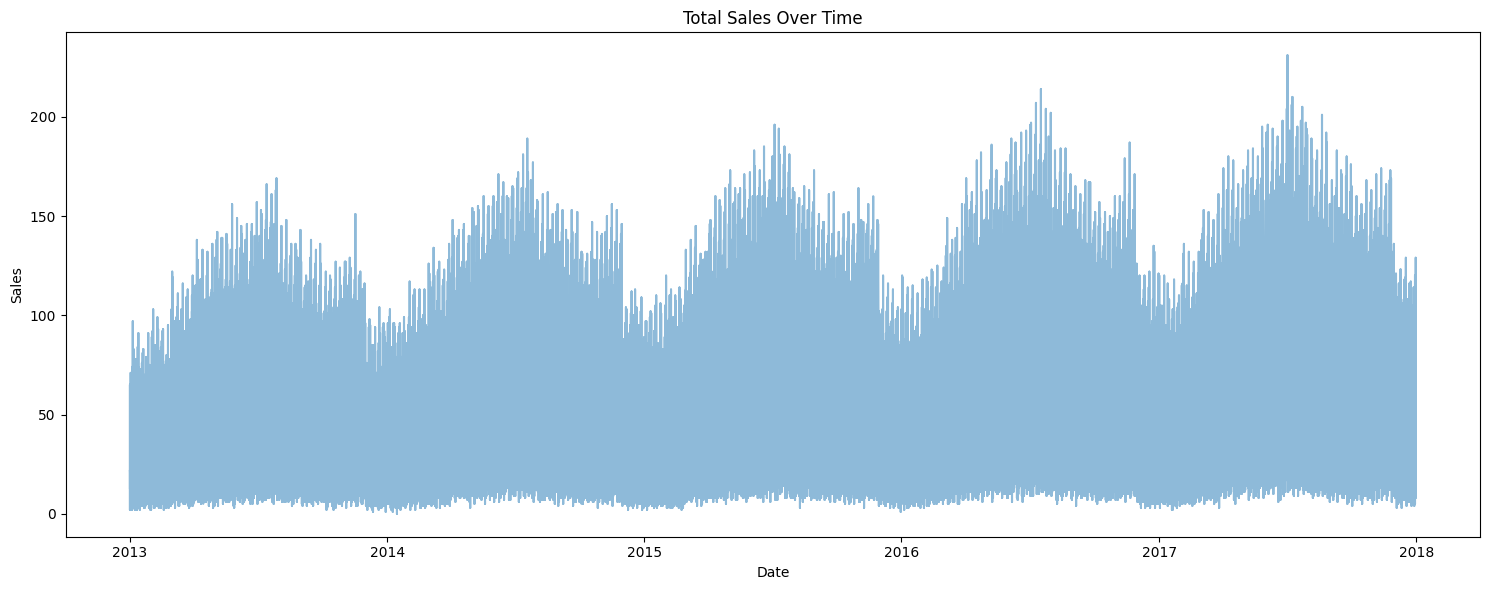

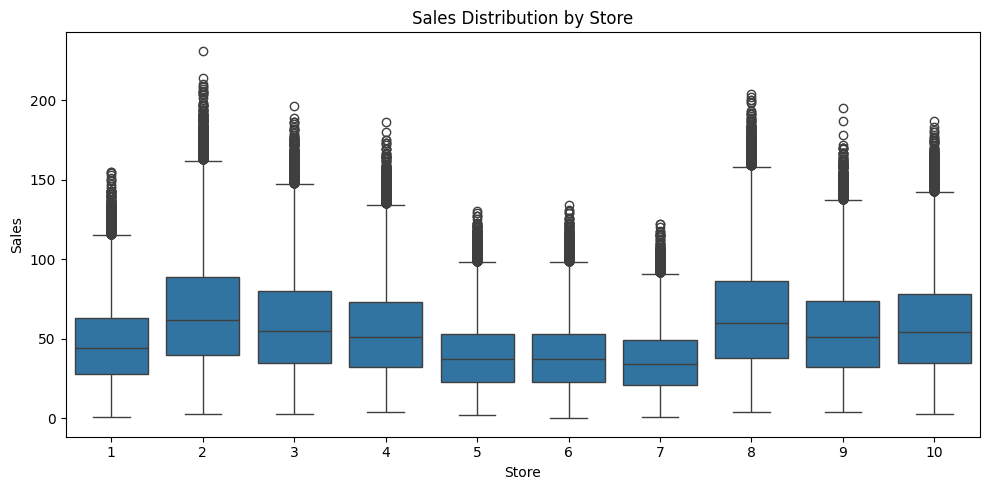

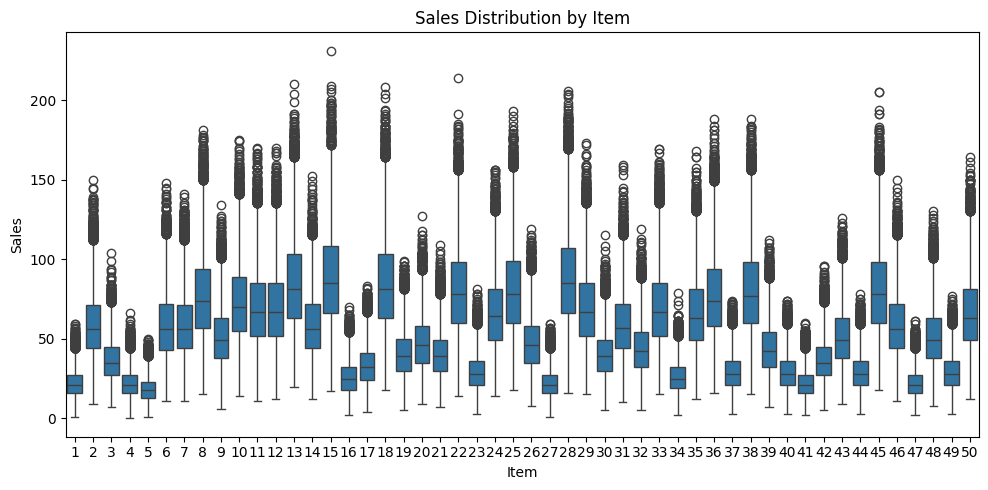

In [4]:
# Visualization of df_train
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
plt.plot(df_train['date'], df_train['sales'], alpha=0.5)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='store', y='sales', data=df_train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='item', y='sales', data=df_train)
plt.title('Sales Distribution by Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


# 4. Train-Validation-Test Split

In [5]:
# Define features and target
features = ['store_encoded', 'item_encoded']
target = 'sales'

# Sort by date to ensure chronological split
df_train_sorted = df_train.sort_values('date')

# Set validation and test size
val_size = 45000
test_size = 45000

# Calculate split points
n_samples = len(df_train_sorted)
train_end = n_samples - (val_size + test_size)
val_end = n_samples - test_size

# Split the data
train_data = df_train_sorted.iloc[:train_end]
val_data = df_train_sorted.iloc[train_end:val_end]
test_data = df_train_sorted.iloc[val_end:]

# Prepare X and y for each split
X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

X_test = test_data[features]
y_test = test_data[target]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (823000, 2)
Validation set shape: (45000, 2)
Test set shape: (45000, 2)


# 5. Feature Engineering

In [6]:
# สร้างฟีเจอร์เชิงเวลา
def create_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    return df

# สร้าง lag features
def create_lag_features(df, lags=[7, 14, 30]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)
    return df

# สร้าง rolling mean features
def create_rolling_features(df, windows=[7, 14, 30]):
    for window in windows:
        df[f'sales_rolling_mean_{window}'] = df.groupby(['store', 'item'])['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
    return df

# Apply feature engineering to train/val/test (ต้องใช้ inplace เพื่อให้ dataset ถูกอัปเดต)
for dataset in [train_data, val_data, test_data]:
    create_time_features(dataset)
    create_lag_features(dataset)
    create_rolling_features(dataset)

# กำหนดฟีเจอร์ใหม่
time_features = ['year', 'month', 'day', 'day_of_week', 'quarter']
lag_features = [f'sales_lag_{lag}' for lag in [7, 14, 30]]
rolling_features = [f'sales_rolling_mean_{window}' for window in [7, 14, 30]]

features = ['store_encoded', 'item_encoded'] + time_features + lag_features + rolling_features

# เตรียม X, y สำหรับแต่ละชุด
X_train = train_data[features]
y_train = train_data['sales']

X_val = val_data[features]
y_val = val_data['sales']

X_test = test_data[features]
y_test = test_data['sales']

# จัดการ missing values จาก lag features
if X_train.isnull().values.any():
    X_train = X_train.fillna(X_train.mean())
if X_val.isnull().values.any():
    X_val = X_val.fillna(X_val.mean())
if X_test.isnull().values.any():
    X_test = X_test.fillna(X_test.mean())

# 6. Model Development


In [7]:
# 6. Model Development (ใช้ features จาก #5 Feature Engineering)

# นำเข้าไลบรารีที่จำเป็น
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# สร้างและกำหนดพารามิเตอร์ของโมเดล
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# รวมโมเดลไว้ใน dict
models = {
    'LightGBM': lgb_model,
    # 'RandomForest': rf_model,
    # 'GradientBoosting': gb_model
}

scores = {}
predictions = {}

# เทรนและประเมินผลแต่ละโมเดลโดยใช้ features จาก #5 Feature Engineering
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    predictions[name] = val_pred
    r2 = r2_score(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    scores[name] = {'R2': r2, 'RMSE': rmse}
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")

# สร้าง weighted ensemble โดยใช้ R2 เป็น weight
weights = {name: score['R2'] for name, score in scores.items()}
total_weight = sum(weights.values())
weights = {name: w/total_weight for name, w in weights.items()}

ensemble_pred = np.zeros_like(y_val, dtype=float)
for name, weight in weights.items():
    ensemble_pred += predictions[name] * weight

ensemble_r2 = r2_score(y_val, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
print(f"\nEnsemble - R2: {ensemble_r2:.4f}, RMSE: {ensemble_rmse:.4f}")



Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 823000, number of used features: 13
[LightGBM] [Info] Start training from score 51.285939
LightGBM - R2: 0.9468, RMSE: 7.8385

Ensemble - R2: 0.9468, RMSE: 7.8385


# 7. Visualization


In [ ]:
# 7. Visualization
# ทดสอบโมเดลแต่ละตัวบน X_test และ plot เทียบกับ actual sales ของ y_test

import plotly.graph_objects as go

# สร้าง dict สำหรับเก็บ prediction ของแต่ละโมเดลบน X_test
test_predictions = {}

for name, model in models.items():
    test_pred = model.predict(X_test)
    test_predictions[name] = test_pred

# สร้าง weighted ensemble บน X_test
ensemble_test_pred = np.zeros_like(y_test, dtype=float)
for name, weight in weights.items():
    ensemble_test_pred += test_predictions[name] * weight
test_predictions['Ensemble'] = ensemble_test_pred

def plot_predictions_test(actual, predictions):
    fig = go.Figure()
    
    # Plot actual values
    fig.add_trace(go.Scatter(
        y=actual,
        name='Actual',
        line=dict(color='blue', width=2)
    ))
    
    # Plot predictions for each model
    colors = ['red', 'green', 'purple', 'orange', 'black']
    line_styles = ['solid', 'dash', 'dot', 'dashdot', 'longdash']
    for (name, pred), color, line_style in zip(predictions.items(), colors, line_styles):
        fig.add_trace(go.Scatter(
            x=np.arange(len(pred)) if 'date' not in predictions else predictions['date'],  # fallback if no date
            y=pred,
            name=name,
            line=dict(color=color, width=2, dash=line_style)
        ))
    
    fig.update_layout(
        title='Sales Predictions on Test Set by Model',
        xaxis_title='Time',
        yaxis_title='Sales',
        hovermode='x unified'
    )
    
    fig.show()

# Plot predictions on test set
plot_predictions_test(y_test, test_predictions)
